# Batch Normalization
This article first covers the prerequisites needed to fully comprehend batch normalization, followed by a detailed introduction of the technique itself. It also reproduces one of the experiments in the original batch normalization paper to help better understand the benefits that batch normalization brings to neural network training.

## Prerequisite
Before diving into batch normalization, we will first wrap up the relevant contexts, i.e., covariate shift and statistical whitening, to properly establish the problem of internal covariate shift in neural network training and see where batch normalization draws its idea from.

### Covariate Shift
Covariate shift refers to the shift in distribution among different sets of data. For example, there may be a covariate shift between training and test data, which could be resulted from the sampling process or that the data come from different "domains". When such a shift exists, it is generally more difficult to yield good generalization performance. The problem of covariate shift is to the central focus of statistics as well as machine learning research, and is typically tackled by data pre-processing or domain adaptation in a more systematic fashion.

### Internal Covaraite Shift
While covariate shift is studied w.r.t. the inputs to a learning system as a whole, in the context of neural networks, we can treat the deeper layers of a network as a separate learning system, with inputs coming from the shallower layers. For simplicity, let's look at a simple network that solely consists of linear transformations. Suppose the network takes random vector $\mathbf{x} \in \mathbb{R}^d$ as input, which has the first and second moments

$$
\begin{align*}
    \boldsymbol\mu_\mathbf{x} = \mathbb{E}[\mathbf{x}] &&
    \Sigma_\mathbf{x} = \mathbb{E}[(\mathbf{x} - \boldsymbol\mu)(\mathbf{x} - \boldsymbol\mu)^\top]
\end{align*}.
$$

After several linear layers, the input is transformed into random vector $\mathbf{h} = W\mathbf{x}$ with first and second moments

$$
\begin{align*}
    \boldsymbol\mu_\mathbf{h} = \mathbb{E}[W\mathbf{x}] = W\boldsymbol\mu_\mathbf{x} &&
    \Sigma_\mathbf{h} = \mathbb{E}[(W\mathbf{x} - W\boldsymbol\mu_\mathbf{x})(W\mathbf{x} - W\boldsymbol\mu_\mathbf{x})^\top] = W\Sigma_\mathbf{x}W^\top.
\end{align*}
$$

If we freeze the parameters of the linear layers, the moments of $\mathbf{h}$, a.k.a. the input to the deeper layers of the network, would remain unchanged. However, with gradient descent, we update $W$ based on the gradient of the loss w.r.t. itself

$$
\begin{align*}
    W \leftarrow W - \eta\nabla_W\mathcal{J}
\end{align*}
$$

which causes the moments to become

$$
\begin{align*}
    \boldsymbol\mu_\mathbf{h} = W\boldsymbol\mu_\mathbf{x} - \eta\nabla_W\mathcal{J}\boldsymbol\mu_\mathbf{x} &&
    \Sigma_\mathbf{h} = W\Sigma_\mathbf{x}W^\top - \boldsymbol\mu_\mathbf{x}W\Sigma_\mathbf{x}(\nabla_WJ)^\top - \boldsymbol\mu_\mathbf{x}(\nabla_WJ)\Sigma_\mathbf{x}W^\top + \boldsymbol\mu_\mathbf{x}^2(\nabla_WJ)\Sigma_\mathbf{x}(\nabla_WJ)^\top.
\end{align*}
$$

Here we observe internal covariate shift. It is arguably true that the problem that covariate shift could cause for the learning system as a whole should be similar to that caused by internal covaraite shift for neural networks. Since the deeper layers need to accommodate for shifted inputs at each epoch, training could be significantly harder in terms of slower convergence speed. Also, for deep sigmoid networks (deep neural networks that use sigmoid as the activation function), the activations could be pushed towards the saturating modes, causing vanishing gradients and dead neurons. It is obvious that such effects could be alleviated by using a smaller learning rate, but it is also at the danger of falling into less optimal local minima and getting stuck in the flat regions during training. Batch normalization chooses to normalize the activations so that the moments are (somewhat) fixed.


### Statistical Whitening
It is well-acknowledged that whitening transformation as a pre-processing step could aid various statistical learning methods by standardizing and decorrelating the input dimensions. Specifically, for random vector $\mathbf{x} \in \mathbb{R}^d$ with first and second moments

$$
\begin{align*}
    \boldsymbol\mu = \mathbb{E}[\mathbf{x}] &&
    \Sigma = \mathbb{E}[(\mathbf{x} - \boldsymbol\mu)(\mathbf{x} - \boldsymbol\mu)^\top],
\end{align*}
$$

statistical whitening aims at applying an affine transformation s.t. the transformed random vector has zero mean and unit covariance

$$
\begin{align*}
    \boldsymbol\mu' = \mathbf{0} &&
    \Sigma' = I
\end{align*}.
$$

For the translation part, the mean is subtracted to center the data. While there exists infinitely many transformations to decorrelate the dimensions of $\mathbf{x}$, the commonly used one is based on eigendecomposition of the covariance matrix. Since $\Sigma$ is positive semi-definite, it can be decomposed into

$$
\begin{align*}
    \Sigma = Q\Lambda Q^{-1}
\end{align*}
$$

where $Q \in \mathbb{R}^{d \times d}$ consists of the eigenvectors in the columns and $\Lambda \in \mathbb{R}^{d \times d}$ consists of corresponding eigenvalues on the diagonal. Furthermore, since $\Sigma$ is symmetric, $Q$ is orthogonal. Therefore, $Q^{-1} = Q^\top$ and $QQ^\top = I$. We have

$$
\begin{align*}
    \Sigma = Q\Lambda Q^\top.
\end{align*}
$$

After applying linear transformation $W$ to the random vector $\mathbf{x}$, the covariance matrix becomes

$$
\begin{align*}
    \Sigma' = W\Sigma W^\top = WQ\Lambda Q^\top W^\top.
\end{align*}
$$

Therefore, to decorrelate the dimensions of $\mathbf{x}$, we can set $W = Q$ so that $\Sigma' = \Lambda$ becomes diagonal. However, to further standardize the variances, we need some other manipulations. Specifically, we observe that

$$
\begin{align*}
    \Sigma = Q\Lambda Q^\top = Q\Lambda^{0.5}\Lambda^{0.5}Q^\top = (Q\Lambda^{0.5}Q^\top)(Q\Lambda^{0.5}Q^\top) = \Sigma^{0.5}\Sigma^{0.5}
\end{align*}
$$

where $\Lambda^{0.5}$ is the matrix derived by raising the diagonal elements of $\Lambda$ to the power of $0.5$. Notice that here we use a rather unconventional notation ($\Sigma^{0.5}$) for simplicity. If we set

$$
\begin{align*}
    W = \Sigma^{-0.5} = (Q\Lambda^{0.5}Q^\top)^{-1} = Q\Lambda^{-0.5}Q^\top,
\end{align*}
$$

we can standardize the covariance matrix:

$$
\begin{align*}
    \Sigma' = W\Sigma W^\top = Q\Lambda^{-0.5}Q^\top Q\Lambda Q^\top Q\Lambda^{-0.5}Q^\top = I.
\end{align*}
$$

Therefore, the overall affine transformation to achieve statistical whitening is

$$
\begin{align*}
    \mathbf{x}' = \Sigma^{-0.5}(\mathbf{x} - \boldsymbol\mu).
\end{align*}
$$

### Computational Complexity of Statistical Whitening
The problem of statistical whitening is that eigendecomposition of the $d \times d$ covariance matrix takes $\mathcal{O}(d^3)$ time. Also, in practice we'll use the sample mean and covariance to estimate the true mean and covariance which takes $\mathcal{O}(Nd)$ and $\mathcal{O}(Nd^2)$ to compute for an $N \times d$ design matrix. As such, these computations would be too heavy for layer-wise normalization in deep neural networks. To accommodate this issue, batch normalization drops the decorrelation part and do standardization only, which becomes

$$
\begin{align*}
    \mathbf{x}' = \frac{\mathbf{x} - \boldsymbol\mu}{\sqrt{\operatorname{Var}[\mathbf{x}]}}
\end{align*}
$$

where the normalization is done dimension-wise separately, resulting in $\mathcal{O}(Nd)$ complexity.

## Batch Normalization
### Backpropagating Through Batch Normalization

## A Simple Case Study of BatchNorm
Here we reproduce the first experiment in the [batch normalization paper](http://proceedings.mlr.press/v37/ioffe15.pdf) to inspect more closely the effect that batch normalization has on the training dynamics of neural networks. The authors studied a rather simple network (MLP with three hidden layers and sigmoid activation function) trained on MNIST.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
class CacheMNIST(Dataset):

    def __init__(self, train=True):
        super(CacheMNIST, self).__init__()
        self.cache = {}
        self.dataset = MNIST(root='./', train=train, transform=T.ToTensor(), download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Since MNIST is a rather small dataset,
        # we cacahe it to memory in the first run to accelerate later epochs.
        if index in self.cache:
            return self.cache[index]

        self.cache[index] = self.dataset[index]
        return self.__getitem__(index)

In [3]:
class MNIST_MLP(nn.Module):

    def __init__(self, num_hidden=3, activation='Sigmoid', use_bn=True):
        super(MNIST_MLP, self).__init__()
        bn_module = nn.BatchNorm1d if use_bn else nn.Identity
        act_module = getattr(nn, activation)

        self.layers = nn.ModuleList()
        for ix in range(num_hidden):
            in_features = 28*28 if ix == 0 else 100
            self.layers.append(nn.Sequential(
                nn.Linear(in_features, 100),
                # Batch normalization is applied immediately after the linear layer
                # to modify only the first and second moments.
                bn_module(100),
                act_module()
            ))

        self.clf = nn.Linear(100, 10)

        # Keep record of the inputs and gradients of the activation functions.
        self.act_inputs = [[] for _ in range(num_hidden)]
        self.act_grads = [[] for _ in range(num_hidden)]
        self.hook_cnt = 0
        for layer in self.layers:
            layer[2].register_full_backward_hook(self.hook)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for ix, layer in enumerate(self.layers):
            x = layer[1](layer[0](x))
            self.act_inputs[ix].append(x.detach().mean().cpu().numpy())
            x = layer[2](x)

        return self.clf(x)

    def hook(self, module, grad_input, grad_output):
        grad_local = grad_input[0] / grad_output[0]
        grad_absmin = torch.min(torch.abs(grad_local))
        ix = len(self.layers) - 1 - self.hook_cnt%len(self.layers)
        self.act_grads[ix].append(grad_absmin.detach().cpu().numpy())
        self.hook_cnt += 1

    def plot_activation_input(self):
        for ix, input in enumerate(self.act_inputs):
            plt.plot(input, label=f'Layer {ix+1}')

        plt.legend(loc='upper right')
        plt.show()

    def plot_activation_grad(self):
        for ix, grad in enumerate(self.act_grads):
            plt.plot(grad, label=f'Layer {ix+1}')

        plt.legend(loc='upper right')
        plt.show()

In [4]:
def train_mnist(model, optimizer, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(CacheMNIST(train=True), batch_size=60, shuffle=True)
    test_loader = DataLoader(CacheMNIST(train=False), batch_size=60)

    # Train for 50000 steps, with 60 examples per mini-batch.
    num_epochs = 50000 // (len(train_loader.dataset) // train_loader.batch_size)
    for epoch in range(num_epochs):
        train_loss = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        with torch.no_grad():
            test_true, test_pred = [], []
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                logits = model(x)
                test_true.append(y.cpu().numpy())
                test_pred.append(logits.argmax(dim=-1).cpu().numpy())

            test_true = np.concatenate(test_true)
            test_pred = np.concatenate(test_pred)

        train_loss = np.mean(train_loss)
        test_acc = accuracy_score(test_true, test_pred)

        if epoch % 5 == 0 or epoch+1 == num_epochs:
            print(f'Epoch {epoch+1}/{num_epochs} | Loss {"%.3f" % train_loss} | Acc {"%.3f" % test_acc}')

First, lets train our network without batch normalization and plot the input and gradient distributions of the activation functions.

Epoch 1/50 | Loss 2.320 | Acc 0.114
Epoch 6/50 | Loss 2.301 | Acc 0.114
Epoch 11/50 | Loss 2.301 | Acc 0.114
Epoch 16/50 | Loss 2.301 | Acc 0.114
Epoch 21/50 | Loss 2.301 | Acc 0.114
Epoch 26/50 | Loss 2.301 | Acc 0.114
Epoch 31/50 | Loss 2.301 | Acc 0.114
Epoch 36/50 | Loss 2.301 | Acc 0.114
Epoch 41/50 | Loss 2.301 | Acc 0.114
Epoch 46/50 | Loss 2.301 | Acc 0.114
Epoch 50/50 | Loss 2.301 | Acc 0.114


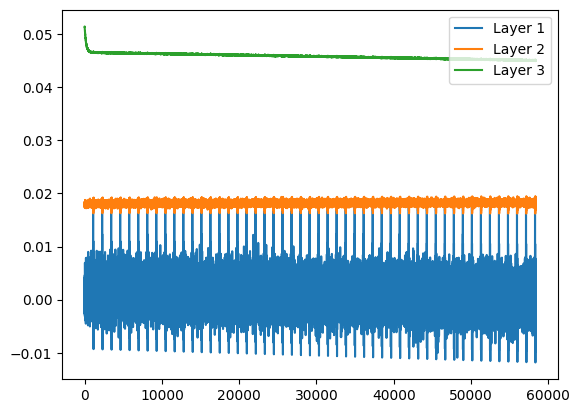

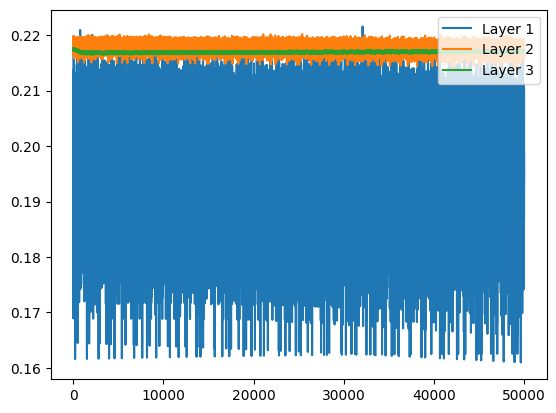

In [5]:
model = MNIST_MLP(num_hidden=3, activation='Sigmoid', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()
model.plot_activation_grad()

It's quite suprising that the network failed to train at all and produces almost the same prediction for all data (given the simplicity of the task we're dealing with). Let's first try to reduce the number of layers in our network.

Epoch 1/50 | Loss 2.291 | Acc 0.154
Epoch 6/50 | Loss 2.137 | Acc 0.550
Epoch 11/50 | Loss 1.883 | Acc 0.661
Epoch 16/50 | Loss 1.553 | Acc 0.721
Epoch 21/50 | Loss 1.259 | Acc 0.770
Epoch 26/50 | Loss 1.044 | Acc 0.805
Epoch 31/50 | Loss 0.894 | Acc 0.825
Epoch 36/50 | Loss 0.788 | Acc 0.840
Epoch 41/50 | Loss 0.710 | Acc 0.852
Epoch 46/50 | Loss 0.652 | Acc 0.859
Epoch 50/50 | Loss 0.615 | Acc 0.864


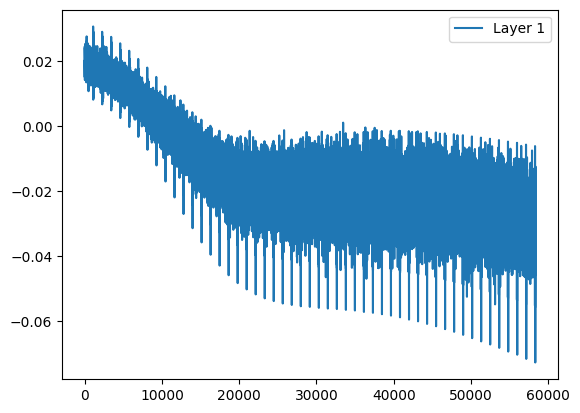

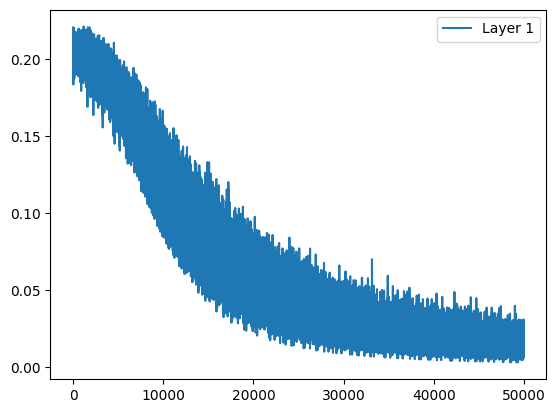

In [6]:
model = MNIST_MLP(num_hidden=1, activation='Sigmoid', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()
model.plot_activation_grad()

We can see that the simpler network trains smoothly and is already quite accurate on this dataset. We here observe the degeneration problem, which is the main focus of the ResNet [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459). Meanwhile, it is well-acknowledged that sigmoid networks are hard to train due to saturating activations and vanishing gradients. However, this is not the problem for this case since the activations are in the linear regions of sigmoid. Let's switch the activation function to ReLU.

Epoch 1/50 | Loss 2.300 | Acc 0.114
Epoch 6/50 | Loss 2.245 | Acc 0.343
Epoch 11/50 | Loss 1.665 | Acc 0.595
Epoch 16/50 | Loss 0.799 | Acc 0.801
Epoch 21/50 | Loss 0.529 | Acc 0.858
Epoch 26/50 | Loss 0.441 | Acc 0.879
Epoch 31/50 | Loss 0.395 | Acc 0.890
Epoch 36/50 | Loss 0.364 | Acc 0.898
Epoch 41/50 | Loss 0.341 | Acc 0.903
Epoch 46/50 | Loss 0.323 | Acc 0.907
Epoch 50/50 | Loss 0.310 | Acc 0.911


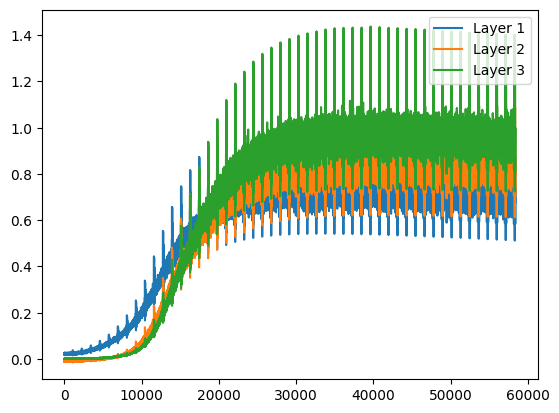

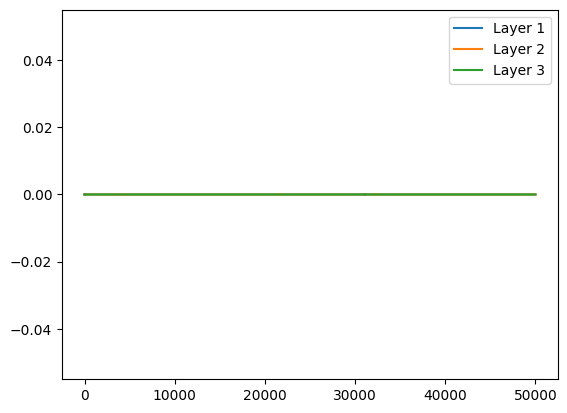

In [7]:
model = MNIST_MLP(num_hidden=3, activation='ReLU', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()
model.plot_activation_grad()

We can clearly see that ReLU is doing a good job here. In fact, there exist many other methods to train deeper networks well, like using residual connections and the [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer. Finally, lets apply BN to the layers.

Epoch 1/50 | Loss 2.015 | Acc 0.704
Epoch 6/50 | Loss 1.102 | Acc 0.871
Epoch 11/50 | Loss 0.773 | Acc 0.896
Epoch 16/50 | Loss 0.607 | Acc 0.905
Epoch 21/50 | Loss 0.510 | Acc 0.912
Epoch 26/50 | Loss 0.446 | Acc 0.915
Epoch 31/50 | Loss 0.399 | Acc 0.920
Epoch 36/50 | Loss 0.360 | Acc 0.925
Epoch 41/50 | Loss 0.328 | Acc 0.929
Epoch 46/50 | Loss 0.298 | Acc 0.934
Epoch 50/50 | Loss 0.277 | Acc 0.937


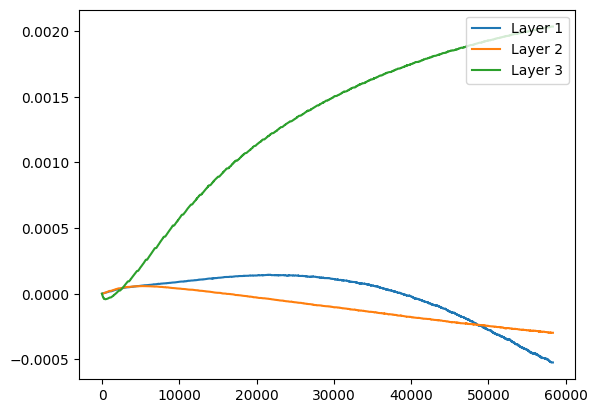

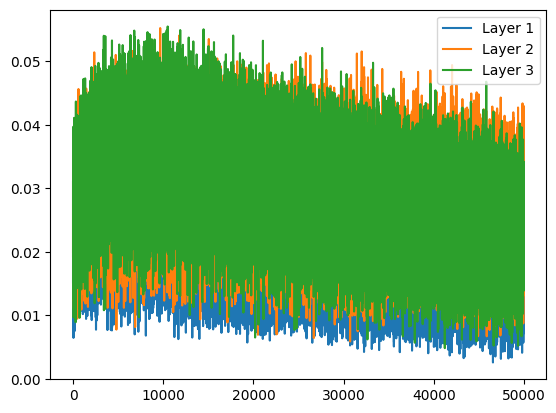

In [8]:
model = MNIST_MLP(num_hidden=3, activation='Sigmoid', use_bn=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()
model.plot_activation_grad()

BN accelatrates training and yields the best result.